# Alternative dot-product predictor function

The source of truth for evaluating our encoder is the CAS9 cleave rate
model from the Finkelstein lab. This function is defined for any pair 
of 20-base sequence inputs, however in order to train a neural network
we need a differentiable function which operates a continuous softmax
representation of bases, so the finkelstein model was converted to one
that does so; the "keras" version, as defined in `cas9_keras.py`. 

This new function matches the old function for any true "one-hot" input --
i.e. any time the softmax value for all bases consists of a single one, 
and three zeros. For less confident inputs, say `[0.6, 0.2, 0.1, 0.1]`,
the function takes on some value, and how we implement the keras version 
determines that value. 

## The problem

One repeated observation while trying to train the encoder is that there is
a preference for uncertainty. It is common to see some (or occasionally,
all) outputs get stuck at `[0.25, 0.25, 0.25, 0.25]`. Sometimes the model 
is able to get very good accuracy from the softmax scoring, which 
falls apart when convert the vectors to one-hot ("true" sequences). 
This model, for example, overfit well to a small subset of data, but does
not work at all once softmax vectors are converted to onehot:

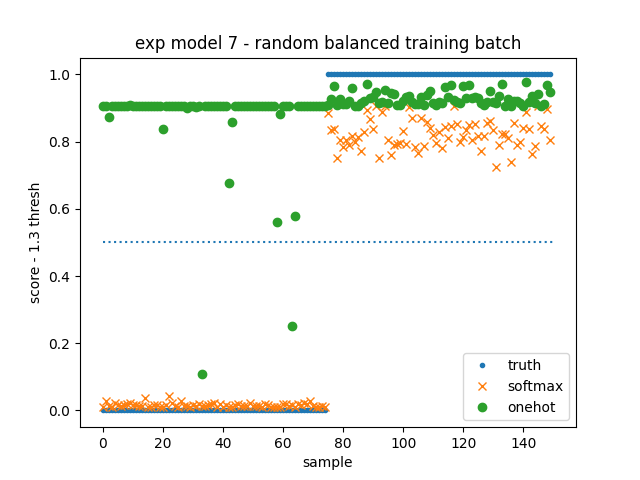

There is an entropy regularizer in the model, which penalizes less 
confident outputs, and this does help increase confidence. I suspect
though that this regularizer will also make it harder for the model to
change any encoder output once it achieves a confident encoding.

Another observation is that the predictor outputs very low values of 
cleave rate for any uncertain sequences. Two identically sequences
which all have 0.8 confidence on the same bases, will score virtually
zero cleaving. In some sense, this could be considered "correct": if you
pick each base in the sequence randomly according the softmax probailities,
chances are high that 2 or more bases will be flipped, and two different 
bases is enough to prevent cleaving. But still this may not be a useful
feature for training an encoder.

## Alternative Function

This notebook explores a possible alternative formulation of the predictor,
which uses the dot-product of each pair of softmax bases to compute the
penalty. Bases incur penalties when they point in different directions. 

Additionally, a confidence factor is defined. For a sequence, the confidence
is defined as the mean (over sequence positions) of the maximum softmax value 
in each position. The confidence for a pair is the product of these two values.

The dot-product score is then offset by 0.5, and scaled by the confidence so
that when confidence is 0, the output is an ambiguous 0.5 and changes
continuously towards the ultimate score as confidence increases. In this way,
confidence is penalized or rewarded based on whether each confident output is
correct (as opposed to the regularizer which rewards confidence regardless of
correctness). 

The plots below show two examples of the scoring function: one in which the
pairs are slowing transitions from random vectors to confident identical
sequences, and one in which they transition from random to confident differing
sequences.


In [2]:
%pylab notebook

# Run on CPU not GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from primo.models.cas9_keras import log10_crispr_spec, log10_norm_crispr_spec,linear_crispr_spec
import primo.tools.sequences as seqtools
import numpy as np
from scipy.interpolate import interp1d

subpen = np.array([-1.7449405080809126, -1.275485084790358, -1.8001827224086722, -1.9323849500279549, -1.6677722398632207, -1.6537370694565101, -1.8981469677400609, -1.0814292717607923, -1.3231152511430453, -0.99840146446464273, -1.2766126030502924, -1.073338813454068, -1.5614374592181826, -1.4737507320504855, -1.298392565410591, -1.0105000195452765, -0.43349702574711524, -0.11665543376814178, -0.17370266801790191, 0.2676084623705467, 0.051835157750172757, 0.08920809165894289, 0.075459598643889569, 0.046975071077932237]).astype(np.float32)
subpen = subpen[:20][::-1]
subtrans = np.array([[ 0.        ,  1.16616601,  0.96671383,  0.94917742],       [ 0.94076049,  0.        ,  1.18426595,  0.87129983],       [ 0.58224486,  1.11064886,  0.        ,  1.04707949],       [ 0.9633753 ,  0.98895548,  1.2293125 ,  0.        ]]).astype(np.float32)
# changes matrices to account for the nucleotide string being 'ACGT', not 'ATCG' as in seqtools.bases and the rest of the PRIMO package
finkel_bases = 'ACGT'
shift = np.array([finkel_bases.index(b) for b in seqtools.bases])
subtrans = subtrans[shift,:][:, shift]
    
### 
# Take a pair of flat vectors as starting points, and slowly change them to a final point
###

def dotproduct_crispr_spec(seq_pairs):
    """Alternative cleave rate model
    
    Normalize the softmax inputs, and take the penalty at each position to be
    one minus the dot product of the two "base vectors", weighted according to the 
    position dependent substitution penalty from the finkelstein paper.
    
    This ignores the base dependent weighting -- i.e. difference between substituting
    A, T, C, or G -- but allows base outputs which are less confident but still
    similar to be evaluated as such during training. 
    
    With the previous function, an input like [0.8, 0.066, 0.066, 0.0.66] / [0.8, 0.066, 0.066, 0.0.66]
    at a single base results in a substantial penalty to cleave rate.
    """
    ref = seq_pairs[:, 0, :, :]
    obs = seq_pairs[:, 1, :, :]
    ref_norm, _ = tf.linalg.normalize(ref, axis=-1)
    obs_norm, _ = tf.linalg.normalize(obs, axis=-1)
    
    m1 = tf.einsum('bij,jk->bijk', ref, subtrans)
    m2 = tf.einsum('bij,bikj->bijk', obs, m1)
    base_factors = tf.reduce_sum(tf.reduce_sum(m2, axis=-1), axis=-1)
    # 1 - Dot product
    x = 1 -  tf.reduce_sum(ref_norm*obs_norm, axis=-1)
    
    scores = tf.reduce_sum(x * base_factors * tf.constant(subpen.flatten(), dtype=tf.float32), -1)
    scores = tf.minimum(0.0, scores)
    return scores

def dotproduct_linearized(mid_point=None):
    """Returns a predictor function which will scale the log10 scores such that the
    given `mid_point` value is 0.5.
    
    mid_point is the output of log10_crispr_spec, and shoudl be on range [log10_lb, log10_ub]
    
    If mid_point is none, cleave rate is linearized; i.e. return 10**log_10_crispr_spec(x)
    """
    power = 10.0
    if mid_point is not None:
        power = 0.5 ** (1 / mid_point)

    def f(seq_pairs):
        """
        seq_pairs batch_size x 2 x SEQLEN x 4
        """
        scores = power ** dotproduct_crispr_spec(seq_pairs)
        confidence = tf.reduce_mean(tf.reduce_max(seq_pairs, -1), axis=2)
        confidence = tf.reduce_prod(confidence, axis=1)
        return 0.5 + (scores - 0.5) * confidence

    return f

# def dotproduct_crispr_spec(seq_pairs):
#     """Alternative cleave rate model
    
#     Normalize the softmax inputs, and take the penalty at each position to be
#     one minus the dot product of the two "base vectors", weighted according to the 
#     position dependent substitution penalty from the finkelstein paper.
    
#     This ignores the base dependent weighting -- i.e. difference between substituting
#     A, T, C, or G -- but allows base outputs which are less confident but still
#     similar to be evaluated as such during training. 
    
#     With the previous function, an input like [0.8, 0.066, 0.066, 0.0.66] / [0.8, 0.066, 0.066, 0.0.66]
#     at a single base results in a substantial penalty to cleave rate.
#     """
#     ref = seq_pairs[:, 0, :, :]
#     obs = seq_pairs[:, 1, :, :]
#     ref_norm, _ = tf.linalg.normalize(ref, axis=-1)
#     obs_norm, _ = tf.linalg.normalize(obs, axis=-1)
    
#     m1 = tf.einsum('bij,jk->bijk', ref, subtrans)
#     m2 = tf.einsum('bij,bikj->bijk', obs, m1)
#     base_factors = tf.reduce_sum(tf.reduce_sum(m2, axis=-1), axis=-1)
#     # 1 - Dot product
#     x = 1 -  tf.reduce_sum(ref_norm*obs_norm, axis=-1)
    
#     scores = tf.reduce_sum(x * base_factors * tf.constant(subpen.flatten(), dtype=tf.float32), -1)
#     scores = tf.minimum(0, scores)
#     return scores

# def dotproduct_linearized(mid_point=None):
#     """
#     Linearize and confidence adjust dotproduct_crispr_spec score
    
#     Designed so that low confidence bases result in ambiguous (0.5)
#     output values, and so that as confidence increases, the value
#     moves steadily either towards 1.0 or 0.0 based on how well the
#     bases match.
#     """
#     power = 10
#     if mid_point is not None:
#         power = 0.5 ** (1 / mid_point)

#     def f(seq_pairs):
#         """
#         seq_pairs: batch_size x 2 x sequence length x 4
#         """
#         scores = power ** dotproduct_crispr_spec(seq_pairs)
#         confidence = tf.reduce_mean((tf.reduce_max(seq_pairs, -1) - 0.25)/0.75, axis=2)
#         confidence = tf.reduce_prod(confidence, axis=1)
#         return 0.5 + (scores - 0.5), confidence

#     return f


def plot_transition(final_pairs):
    # Start from a completely random softmax vector, where every position has 
    # 25% probaility of being each base
    random_seq = np.repeat(np.array([0.25, 0.25, 0.25, 0.25])[:, None], 20, axis=1).T
    start_pair = np.repeat(random_seq[None, :, :], 2, axis=0)
    
    # Create softmax version of the ending pair sequence values
    end_pair = seqtools.seqs_to_onehots(final_pairs)
    
    # create array of softmax pairs by interpolating between the start and end,
    # to simulate the training path of moving from random vectors to that
    # particular onehot vector
    end_interp = interp1d([0.0, 1.0], np.array([start_pair, end_pair]), axis=0)
    x = np.linspace(0.0, 1.0, 100)
    pair_array = end_interp(x)
    
    scores, confidence = dotproduct_linearized()(tf.convert_to_tensor(pair_array, dtype=np.float32))
    old_scores = linear_crispr_spec()(tf.convert_to_tensor(pair_array, dtype=np.float32))
    plt.figure()
    plt.plot(x, scores, ':', label='score')
    plt.plot(x, confidence, ':', label='confidence')
    plt.plot(x, 0.5 + (scores - 0.5) * confidence, label='product')
    plt.plot(x, old_scores, label='original')
    plt.suptitle(f"{final_pairs[0]}\n{final_pairs[1]}", fontdict={'family': 'monospace'})
    plt.legend(loc='upper center')

pair1 = [
    'AAAAAAAAAAAAAAAAAAAA',
    'AAAAAAACCGGAAATTTAAA',
]
pair2 = [
    'AAAAAAACCGGAAATTTAAA',
    'AAAAAAACCGGAAATTTAAA',
]

plot_transition(pair1)
plot_transition(pair2)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vuv5zut5 because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib


ValueError: too many values to unpack (expected 2)

<IPython.core.display.Javascript object>


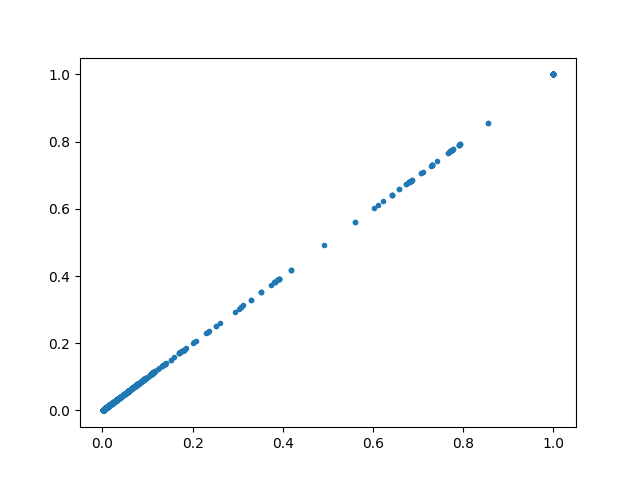

In [3]:
from primo.models.cas9 import crispr_specificity
pairs, dists = seqtools.random_mutant_pairs(10000, 20)
# take the array of pairs and convert to onehots
onehot_pairs = tf.convert_to_tensor(
    seqtools.seqs_to_onehots(pairs.flatten()).reshape(-1, 2, 20, 4),
    dtype = tf.float32
)

python_scores = np.array([crispr_specificity(a, b) for a, b in pairs])

keras_scores = 10**dotproduct_crispr_spec(
    onehot_pairs
).numpy()

plt.figure()
plt.plot(python_scores, keras_scores, '.')